In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/Ml/nbs/dl2/



from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


Mounted at /content/gdrive
/content/gdrive/MyDrive/Ml/nbs/dl2


In [2]:
#export

from exp.nb_05b import *
torch.set_num_threads(2)
def get_data():
    import os
    import torchvision.datasets as datasets
    root = '../data'
    if not os.path.exists(root):
        os.mkdir(root)
    train_set = datasets.MNIST(root=root, train=True, download=True)
    test_set = datasets.MNIST(root=root, train=False, download=True)
    x_train, x_valid = train_set.data.split([50000, 10000])
    y_train, y_valid = train_set.targets.split([50000, 10000])
    return (x_train.view(50000, -1) / 256.0), y_train.float(), (x_valid.view(10000, -1))/ 256.0, y_valid.float()

## ConvNet

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=3641)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.9162e-08), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [10]:
##중요!!!
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize), # nn.module을 사용해서 클래스를 만들고 그 안에 함수 넣으면 sequential 돌릴 수 있음
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1), # adaptiveavgpool : 끝 차원만 정해주면 stride랑 패딩 알아서 정해줌
        Lambda(flatten),
        nn.Linear(32,int(data.c))
    )

In [11]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.0588375, tensor(0.2900)]
valid: [1.0025263671875, tensor(0.6919)]
CPU times: user 7.25 s, sys: 130 ms, total: 7.38 s
Wall time: 4.02 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=3799)

In [15]:
# Somewhat more flexible way
device = torch.device('cuda',0) # gpu number
# parameters, input move to gpu

In [16]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device) # move the model to gpu machine
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [17]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device) # only use when u have only one gpu

In [18]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [1.9218946875, tensor(0.3411, device='cuda:0')]
valid: [0.679074853515625, tensor(0.7889, device='cuda:0')]
train: [0.3598491796875, tensor(0.8894, device='cuda:0')]
valid: [0.2299199951171875, tensor(0.9314, device='cuda:0')]
train: [0.17356861328125, tensor(0.9485, device='cuda:0')]
valid: [0.2357206298828125, tensor(0.9204, device='cuda:0')]
CPU times: user 4.35 s, sys: 1.24 s, total: 5.59 s
Wall time: 13.9 s


Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function:

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=3961)

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [24]:
#export
## mnist_resize 대신에 flexible하게 모든 데이터를 resize할 수 있어야 함.
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm #transformation function
    def begin_batch(self): self.run.xb = self.tfm(self.xb) # transform

# partial을 이용해서 transform 콜백에 넣어서 리사이즈 갈아끼도록 만듬
def view_tfm(*size):
    print(((-1,)+size))
    def _inner(x): 
        print(size)
        return x.view(*((-1,)+size))
    return _inner

In [25]:
 view_tfm(1,28,28)

(-1, 1, 28, 28)


<function __main__.view_tfm.<locals>._inner>

In [26]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

(-1, 1, 28, 28)


With the `AdaptiveAvgPool`, this model can now work on any size input:

In [27]:
nfs = [8,16,32,32] # filters

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], int(data.c))]

# general version // get some number of filters.
# why start with 5? and after 3 is fixed? ==> 3*3 = 9 and outut is 8  : this means just reordering not the any meaningful computation.
def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [29]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [30]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [31]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [32]:
run.fit(3, learn)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

In [33]:
'''
CNN 설명
초반에 3*3채널로 channel 8개로 줄이면, 9 -> 8개로 변하는 것이므로 의미가 없고 단순 shuffle 수준의 정보만을 담는다.
따라서 큰 정보를 갖고 추출의 정보를 담도록 5*5로 시작해서 8개로 줄여야  25-8개로 정보를 요약 및 추출한다.
그것이 초반에 필터 크기를 크게 하는 이유이다. 또는 너무 크게 만들필요도 없는 것이 9 -> 15하면 똑같은 정보를 가지고 공간만 더 크게 만들어서 wasting이다.

필터 여러개는 각자 학습을 통해 경계값들을 구분하도록 정보를 학습하고 초반의 작은 크기가 완전 새로운 양상을 만든다.
단순한 이미지 일 수록 많은 필터를 가진 깊은 구조를 구성할 필요가 없다.

'''

'\nCNN 설명\n초반에 3*3채널로 channel 8개로 줄이면, 9 -> 8개로 변하는 것이므로 의미가 없고 단순 shuffle 수준의 정보만을 담는다.\n따라서 큰 정보를 갖고 추출의 정보를 담도록 5*5로 시작해서 8개로 줄여야  25-8개로 정보를 요약 및 추출한다.\n그것이 초반에 필터 크기를 크게 하는 이유이다. 또는 너무 크게 만들필요도 없는 것이 9 -> 15하면 똑같은 정보를 가지고 공간만 더 크게 만들어서 wasting이다.\n\n필터 여러개는 각자 학습을 통해 경계값들을 구분하도록 정보를 학습하고 초반의 작은 크기가 완전 새로운 양상을 만든다.\n단순한 이미지 일 수록 많은 필터를 가진 깊은 구조를 구성할 필요가 없다.\n\n'

## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [34]:
import torch
# torch.nn.ModuleList?

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=4353)

In [35]:
# 레이어들을 modulelist에 담아서 그것을 순차적으로 실행하게하는 클래스
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
            # print(i,x.data[:2,:1,:2,:2])
            # print(x.data.mean())
        return x
    
    def __iter__(self): return iter(self.layers)

In [36]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [37]:
run.fit(1, learn)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

Now we can have a look at the means and stds of the activations at the beginning of training.

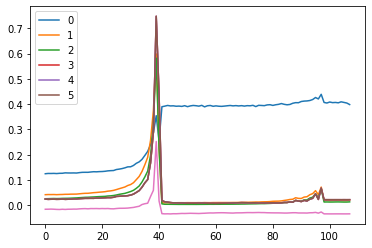

In [38]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));
# 초반에 굉장히 불안함, gradient가 매우 커서 확확 벌어지고 나중에 gradient가 0에 가까워서 거의 안 변함
# x는 이터레이션 or batch

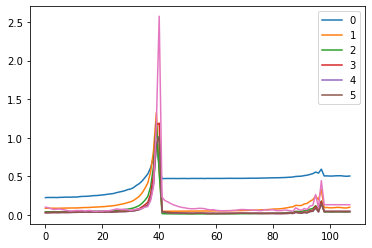

In [41]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

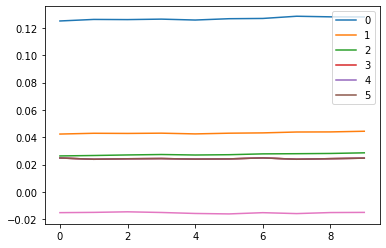

In [42]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));
# std가 점차적으로 계속 줄어듬 그리고 점차 gradient가 큰 차이가 없게 될 것으로 보임

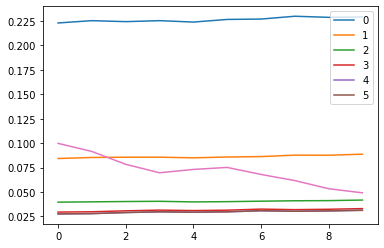

In [43]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [ ]:
# pytorch callback 대신 hook이라는 용어를 쓴다.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=4693)

In [44]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [45]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [46]:
def append_stats(i, mod, inp, outp): # model layer,(module, model_input, model_output) 3가지 필수임
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [47]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(1, learn)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

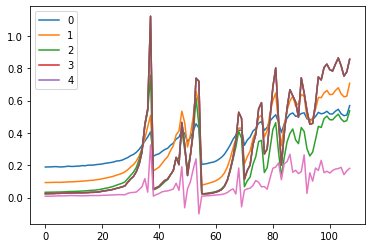

In [49]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=4836)

In [50]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove() # when python clear the memory, automatically call this dunder

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [51]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [52]:
hooks = [Hook(l, append_stats) for l in children(model[:4])] # layer module을 받아와서 그 레이어에 register_forward_hook을 하겠다.

In [53]:
run.fit(1, learn)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

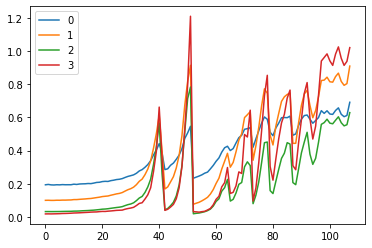

In [54]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=4972)

In [55]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [56]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [57]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [58]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [59]:
#export
from torch.nn import init
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove() # when python clear the memory, automatically call this dunder

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [60]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [61]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f668e1bdd10>, <__main__.Hook object at 0x7f668e1bd390>, <__main__.Hook object at 0x7f668e1bd690>, <__main__.Hook object at 0x7f66a84ed110>, <__main__.Hook object at 0x7f66a84ed850>, <__main__.Hook object at 0x7f66a84edc10>, <__main__.Hook object at 0x7f668e0c0790>]

In [62]:
hooks.remove()

In [63]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [64]:
x.mean(),x.std()

(tensor(0.0065, device='cuda:0'), tensor(1.0070, device='cuda:0'))

In [65]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2250, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3795, device='cuda:0', grad_fn=<StdBackward>))

In [66]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [67]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4007, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8466, device='cuda:0', grad_fn=<StdBackward>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

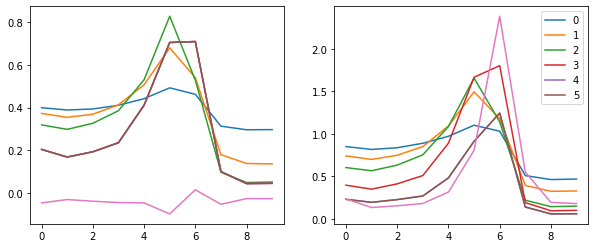

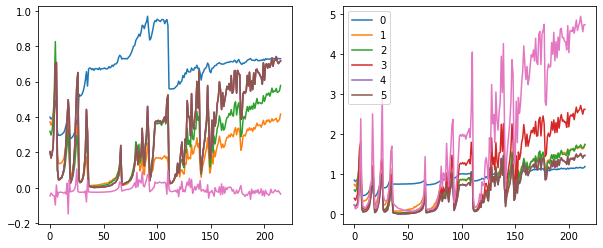

In [68]:
#with 끝나면 hooks의 __exit__이 실행되는 것
with Hooks(model, append_stats) as hooks: 
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=5233)

In [69]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [70]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [71]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [72]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 

In [73]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=5582)

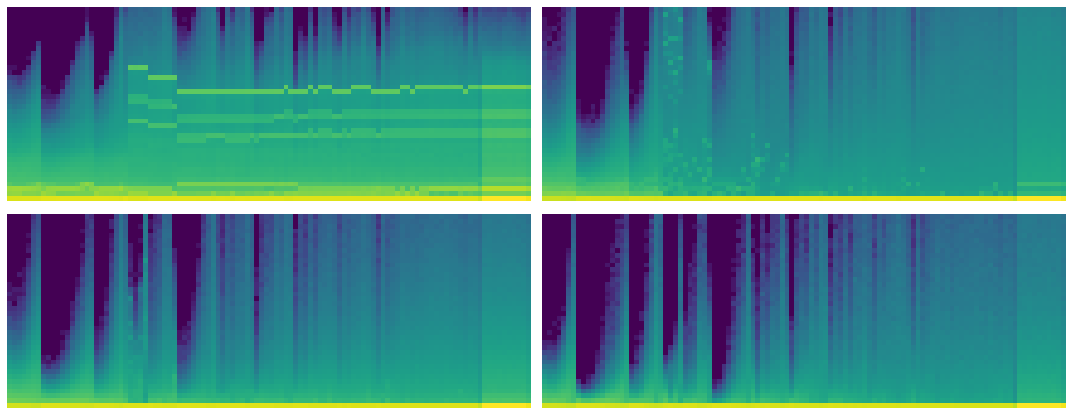

In [74]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()
# x는 iteration
# subplot들은 각각 순서대로 레이어
# y는 activation 분포, 한 iteration에서 activation이 어떤 값들을 들고 있는지 범위 표시
# 노란선은 0을 의미

From the histograms, we can easily get more informations like the min or max of the activations

In [80]:
# 
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    print(h.stats[2],end='=================\n')
    print(h.stats[1],end='=================\n')
    print(h.stats[0])
    return h1[:2].sum(0)/h1.sum(0)


[tensor([4.6180e+05, 1.0233e+05, 1.2217e+05, 2.7729e+04, 1.6867e+04, 1.4128e+04,
        1.2261e+04, 1.0317e+04, 8.4630e+03, 6.2950e+03, 4.7570e+03, 3.9360e+03,
        3.1070e+03, 2.4460e+03, 1.6860e+03, 1.3740e+03, 9.7900e+02, 7.5700e+02,
        5.5000e+02, 3.5000e+02, 1.9200e+02, 1.3900e+02, 7.9000e+01, 4.9000e+01,
        3.7000e+01, 1.5000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]), tensor([4.6170e+05, 1.0486e+05, 1.2986e+05, 2.1354e+04, 1.6636e+04, 1.3832e+04,
        1.2221e+04, 1.0093e+04, 8.0000e+03, 5.9620e+03, 4.4560e+03, 3.5590e+03,
        2.7700e+03, 2.1460e+03, 1.6850e+03, 1.2220e+03, 8.2700e+02, 6.2200e+02,
        4.1200e+02, 2.3000e+02, 1.5400e+02, 9.3000e+01, 6.5000e+01, 3.5000e+01,
        2.1000e+01, 1.2000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

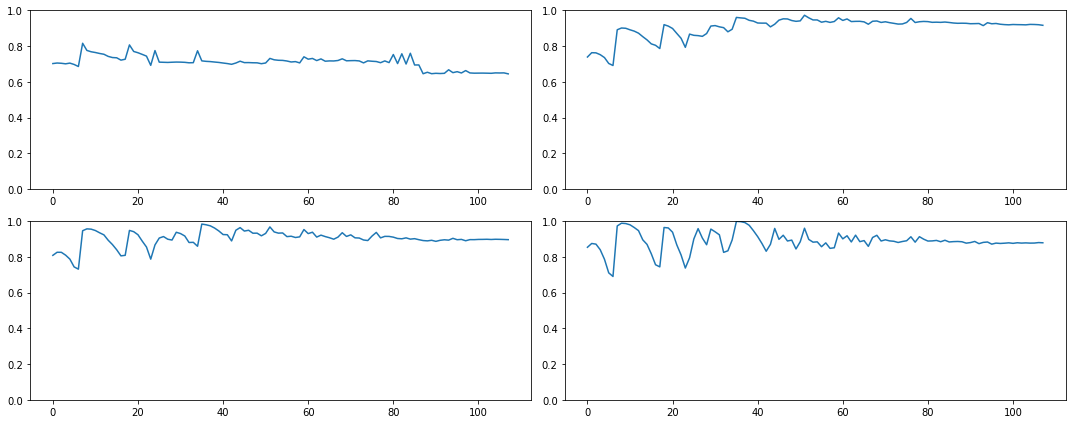

In [81]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()
# 총 배치트레이닝에서 거의 전부가 activation이 0이거나 그에 근접한다
# 학습이 안 된다는 것이다.

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=5390)

In [ ]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.54654125, tensor(0.8278, device='cuda:0')]
valid: [0.15122969970703126, tensor(0.9572, device='cuda:0')]


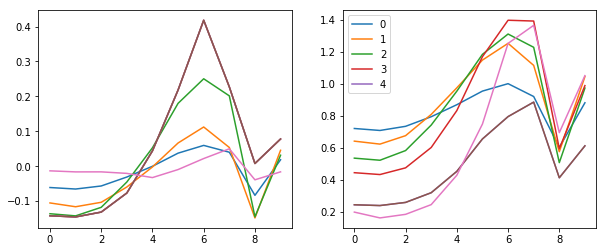

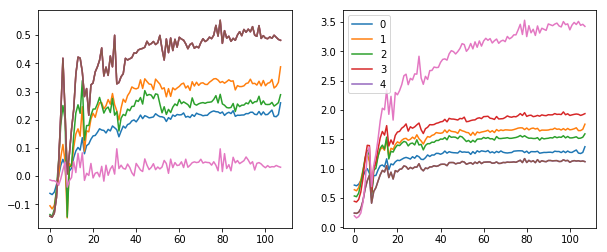

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

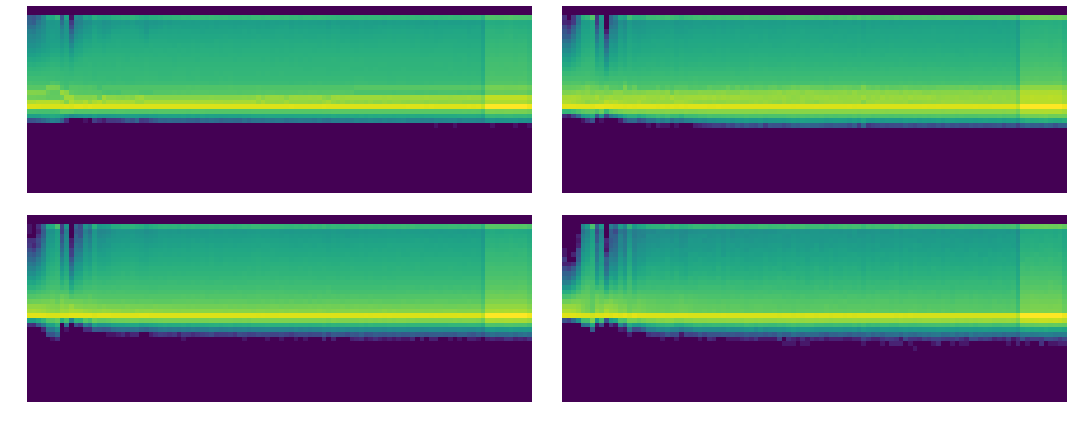

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

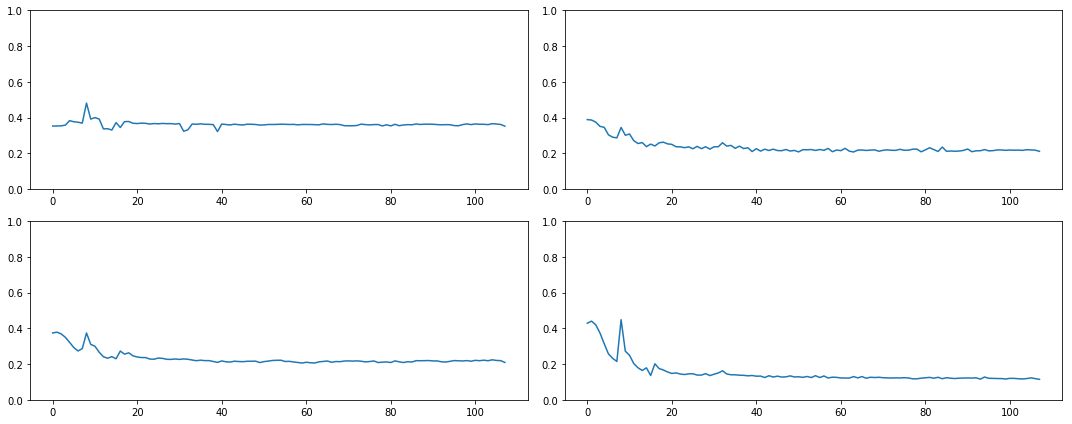

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

[Jump_to lesson 10 video](https://course19.fast.ai/videos/?lesson=10&t=5705)

In [ ]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [1.177220859375, tensor(0.6270, device='cuda:0')]
valid: [0.331805712890625, tensor(0.8985, device='cuda:0')]
train: [0.3674151171875, tensor(0.8885, device='cuda:0')]
valid: [0.394902099609375, tensor(0.8691, device='cuda:0')]
train: [0.29181142578125, tensor(0.9135, device='cuda:0')]
valid: [0.12695498046875, tensor(0.9642, device='cuda:0')]
train: [0.11358849609375, tensor(0.9647, device='cuda:0')]
valid: [0.1171941650390625, tensor(0.9657, device='cuda:0')]
train: [0.0813043896484375, tensor(0.9754, device='cuda:0')]
valid: [0.102300390625, tensor(0.9715, device='cuda:0')]
train: [0.057199677734375, tensor(0.9825, device='cuda:0')]
valid: [0.07670272216796875, tensor(0.9786, device='cuda:0')]
train: [0.04207271484375, tensor(0.9870, device='cuda:0')]
valid: [0.06070926513671875, tensor(0.9811, device='cuda:0')]
train: [0.03412069091796875, tensor(0.9899, device='cuda:0')]
valid: [0.06048909301757813, tensor(0.9826, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True, # uniform 분포는 0에 가까이 나올 경우가 거의 없어서 좀더 richness해서 distribution의 이점을 챙긴다.
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [1.13958578125, tensor(0.6487, device='cuda:0')]
valid: [0.3293475341796875, tensor(0.8952, device='cuda:0')]
train: [0.3618896484375, tensor(0.8904, device='cuda:0')]
valid: [0.19215552978515624, tensor(0.9407, device='cuda:0')]
train: [0.20206876953125, tensor(0.9378, device='cuda:0')]
valid: [0.12095736083984375, tensor(0.9660, device='cuda:0')]
train: [0.123935849609375, tensor(0.9618, device='cuda:0')]
valid: [0.14329190673828124, tensor(0.9567, device='cuda:0')]
train: [0.10821904296875, tensor(0.9675, device='cuda:0')]
valid: [0.07789203491210937, tensor(0.9778, device='cuda:0')]
train: [0.0598996728515625, tensor(0.9809, device='cuda:0')]
valid: [0.07529915771484375, tensor(0.9769, device='cuda:0')]
train: [0.0429351416015625, tensor(0.9866, device='cuda:0')]
valid: [0.06512515869140625, tensor(0.9809, device='cuda:0')]
train: [0.0341603076171875, tensor(0.9898, device='cuda:0')]
valid: [0.06295247802734374, tensor(0.9822, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [ ]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()

<IPython.core.display.Javascript object>